# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False, as_frame=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [26]:
def blur_image(f, kernelG):
    '''
    Input: 
    f - figure or image for blurring: 28 x 28 matrix containing an image (or figure)
    kernelG - 3 x 3 matrix including kernel to be applied to blur the image
    Output:
    Return figure/image blurred
    '''
    #Make a copy of the figure
    fb = f.copy()
    
    # for loops to go trough each pixel of the 28 x 28 image (f)
    for i in range(1,f.shape[0]-1):
        for j in range(1,f.shape[1]-1):
            # For a (i,j) point in the image, apply kernel, and return value to fb (copy of the image)
            fb[i,j] = np.multiply(f[i-1:i+2, j-1:j+2], kernelG).sum()
    #Return blurred immage
    return(fb)

def blur_data_set(data, kernelG):
    '''
    Input: 
    data: array including all the images to be blurred
    kernelG: 3x3 matrix including kernel information to blur image
    '''
    # Create an empty list to store blurred images or figures
    fig_list = []
    
    # For each image in data, reshape image to 28 x28, blur immage using kernelg, and add it to list of blurred images
    for image in data:
        figure = np.reshape(image,(28,28))
        fig_blr = blur_image(figure, kernelG)
        fig_list.append(np.reshape(fig_blr,(fig_blr.shape[0]*fig_blr.shape[1],1)).T)
    
    # Return array of blurred images
    return (np.reshape(np.array(fig_list), (data.shape[0], (28*28))  )  )

                     KNN Models  Accuracy
0                   No Blurring     0.884
1          Only Train Data Blur     0.907
2            Only Dev Data Blur     0.868
3  Both Train and Dev data Blur     0.905


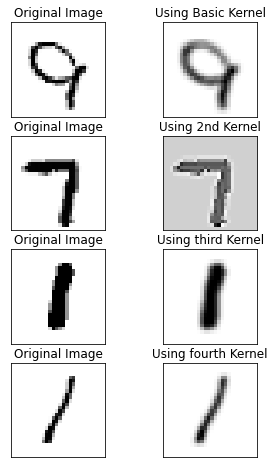

In [28]:
def Q1(train_data, train_labels, dev_data, dev_labels):
    
### STUDENT START ###

    k = 1

    #List to store accuracy scores for models
    accuracy = []
    
    #Matrix and Kernel to be used for blurring
    matrix_kernel = np.reshape(np.array([1, 1, 1, 1 , 1, 1, 1, 1, 1]),(3,3))
    kernelG = matrix_kernel/matrix_kernel.sum()
    
    #Apply kernel to train data (mini_train_data)
    train_data_blr = blur_data_set(train_data, kernelG)
    #Apply kernel(blur) to development data
    dev_data_blr = blur_data_set(dev_data, kernelG)
    
    #First - set, fit and get accuracy of KNN model without any blurring
    model_no_blr = KNeighborsClassifier(n_neighbors=k)
    model_no_blr.fit(train_data, train_labels)
    accuracy.append(model_no_blr.score(dev_data,dev_labels))

    #Second - set, fit and get accuracy of KNN model using taining data blurred, but not dev images.
    model_blr_train = KNeighborsClassifier(n_neighbors=k)
    model_blr_train.fit(train_data_blr, train_labels)
    accuracy.append(model_blr_train.score(dev_data,dev_labels))

    #Third - set, fit and get accuracy of KNN model using blurred dev data, but not training images
    model_blr_dev = KNeighborsClassifier(n_neighbors=k)
    model_blr_dev.fit(train_data, train_labels)
    accuracy.append(model_blr_dev.score(dev_data_blr,dev_labels))
    
    #Fourth - set, fit and get accuracy of KNN model using both train and develoment blurred images
    model_blr_both = KNeighborsClassifier(n_neighbors=k)
    model_blr_both.fit(train_data_blr, train_labels)
    accuracy.append(model_blr_both.score(dev_data_blr,dev_labels))

    # Create and print a dataframe summarizing accuracy data for each model
    df_accuracy = pd.DataFrame({"KNN Models": ["No Blurring", "Only Train Data Blur", 
                                               "Only Dev Data Blur", "Both Train and Dev data Blur"],
                                "Accuracy": accuracy})
    print(df_accuracy)

    #Print Examples of images being blurred using different filters (kernels)
    fig1, axs_q1 = plt.subplots(nrows=4, ncols=2, figsize=(5, 8))

    # Turn off tick marks.
    plt.setp(axs_q1, xticks=(), yticks=())
    
    i = 5
    # Using basic Kernel 
    matrix_kernel = np.reshape(np.array([1, 1, 1, 1 , 1, 1, 1, 1, 1]),(3,3))
    kernelG = matrix_kernel/matrix_kernel.sum()

    axs_q1[0,1].imshow(blur_image(np.reshape(train_data[i,:],(28,28)),kernelG), cmap=plt.cm.Greys)
    axs_q1[0,1].set_title("Using Basic Kernel")
    axs_q1[0,0].imshow(np.reshape(train_data[i,:],(28,28)), cmap=plt.cm.Greys)
    axs_q1[0,0].set_title("Original Image")

    # Using second Kernel 
    matrix_kernel = np.reshape(np.array([0, -0.5, 0, -0.5 , 3, -0.5, 0, -0.5, 0]),(3,3))
    kernelG = matrix_kernel/matrix_kernel.sum()

    axs_q1[1,1].imshow(blur_image(np.reshape(train_data[i+1,:],(28,28)),kernelG), cmap=plt.cm.Greys)
    axs_q1[1,1].set_title("Using 2nd Kernel")
    axs_q1[1,0].imshow(np.reshape(train_data[i+1,:],(28,28)), cmap=plt.cm.Greys)
    axs_q1[1,0].set_title("Original Image")

    # Using third Kernel 
    matrix_kernel = np.reshape(np.array([1,2,1,2,4,2,1,2,1]),(3,3))
    kernelG = matrix_kernel/matrix_kernel.sum()

    axs_q1[2,1].imshow(blur_image(np.reshape(train_data[i+2,:],(28,28)),kernelG), cmap=plt.cm.Greys)
    axs_q1[2,1].set_title("Using third Kernel")
    axs_q1[2,0].imshow(np.reshape(train_data[i+2,:],(28,28)), cmap=plt.cm.Greys)
    axs_q1[2,0].set_title("Original Image")

    # Using fourth Kernel 
    matrix_kernel = np.reshape(np.array([1,2,1,2,4,2,1,2,1]),(3,3))
    kernelG = matrix_kernel/matrix_kernel.sum()

    axs_q1[3,1].imshow(blur_image(np.reshape(train_data[i+3,:],(28,28)),kernelG), cmap=plt.cm.Greys)
    axs_q1[3,1].set_title("Using fourth Kernel")
    axs_q1[3,0].imshow(np.reshape(train_data[i+3,:],(28,28)), cmap=plt.cm.Greys)
    axs_q1[3,0].set_title("Original Image")
 
    plt.show()

    return(train_data_blr, dev_data_blr)
    

### STUDENT END ###

mtb, ddb = Q1(mini_train_data, mini_train_labels, dev_data, dev_labels)



### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [29]:
def binarize1(data, factor):
    '''
    USED TO TEST BINARIZATION BY HAND:
    Function to binarize images (data), using an adjustment factor (factor).
    Return binarized image.
    '''
    #List to store binarized images
    im_list = []
    
    #For image in data, binarize image (bin_image), and add it to the list of binarized images
    for image in data:
        bin_image = np.where(image > image.mean()*factor, 1, 0)
        im_list.append(np.reshape(bin_image,(1, 28*28)))
    
    #Return binarized image
    return(np.reshape(np.array(im_list), (len(im_list), 28*28)))

In [32]:
def trianarize(data, t1, t2):
    '''
    Function to trinarize images included in (data), using an threshold factors (t1 and t2).
    Return binarized image.
    '''
    #List to store trinarized images    
    im_list = []
    
    #For each image in data, trinarize image, and add it to the list of trinarized images
    for image in data:
        image = np.where(image < t1, 0, image )                  #Set to 0 for values below t1
        image = np.where((image > t2), 2, image )                #Set to 2 for values above t2
        image = np.where((image != 0) & (image !=2), 1, image )  #Set to 1 for values different that 0 or 2
        im_list.append(np.reshape(image,(1, 28*28)))             #Add trinarized image to list
    #Return list of trinarized images
    return(np.reshape(np.array(im_list), (len(im_list), 28*28)))    

In [51]:
# Solution with binarization by explicit binarize function

def Q2(train_data, train_labels, dev_data, dev_labels):

### STUDENT START ###

    #Alpha for BernoulliNB model
    alpha = 1
    
    print("MODEL ACCURACY RESULTS:")
    # Binarize train and development data (using routine to test binarization by hand)
    binarized_train_data = binarize1(train_data, 1.5)
    binarized_dev_data = binarize1(dev_data, 1.5)
    
    #Set, fit and print accuracy of model using binarized image (leveraging test routine to binarize)
    clf = BernoulliNB(alpha=alpha)
    clf.fit(binarized_train_data, train_labels)
    print ('Model 1 - binarized (using test routine): %3.4f' %clf.score(binarized_dev_data, dev_labels))
    
    #Set, fit and print accuracy of model using a binarize factor of 0.1
    clf2 = BernoulliNB(alpha=alpha, binarize=0.1)
    clf2.fit(train_data, train_labels)
    print ('Model 2 - binarized (using binarize factor of 0.1): %3.4f' %clf2.score(dev_data, dev_labels))

    #Trianize train data and development data
    trianized_train_data = trianarize(train_data, 0.1, 0.9)
    trianized_dev_data = trianarize(dev_data, 0.1, 0.9)

    #Set, fit and print accuracy for MultinomialNB model using trinarized image
    clf3 = MultinomialNB(alpha=alpha)
    clf3.fit(trianized_train_data, train_labels)
    print ('Model 3 - Trianized (using 0.1 and 0.9 as tresholds): %3.4f' %clf3.score(trianized_dev_data, dev_labels))    

    #Trianize train data and development data
    trianized_train_data = trianarize(train_data, 0.25, 0.8)
    trianized_dev_data = trianarize(dev_data, 0.25, 0.8)

    #Set, fit and print accuracy for MultinomialNB model using trinarized image
    clf4 = MultinomialNB(alpha=alpha)
    clf4.fit(trianized_train_data, train_labels)
    print ('Model 4 - Trianized (using 0.25 and 0.85 as tresholds): %3.4f' %clf4.score(trianized_dev_data, dev_labels))    

    
### STUDENT END ###

Q2(mini_train_data, mini_train_labels, dev_data, dev_labels)

MODEL ACCURACY RESULTS:
Model 1 - binarized (using test routine): 0.8210
Model 2 - binarized (using binarize factor of 0.1): 0.8140
Model 3 - Trianized (using 0.1 and 0.9 as tresholds): 0.8070
Model 4 - Trianized (using 0.25 and 0.85 as tresholds): 0.8130


**ANSWER: Does the multinomial version improve the results? Why or why not?**    
The accuracy of the Multinomial model does not improve versus BernoulliNB (binarized).  The thresholds used for trinarization have a small impact in accuracy.  As it can be seen in table above, when using tresholds of 0.1 and 0.9 (for trinarization), the accuracy is 0.8070.  However, accuracy goes up to 0.8130 when tresholds are 0.25 and 0.85.  
The fact that trinarization does not improve performance seems to indicate that there is not enough variability in the values of the pixels in the figures for a trinarization to have an impact versus binarization. In other words, splitting values in two (binarization) provides the same information as splitting values in three levels.  Thus one of the three levels is redundant, and it is not adding additional information about the image.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [54]:
def Q3(alphas, train_data, train_labels):

### STUDENT START ###
    
    #Create a model with binarize equal to zero
    clf = BernoulliNB(binarize=0)
    
    # Create a searchgrid model using BernoulliNB model (clf), the range of alphas to test, 5-fold crss validation
    gs_clf = GridSearchCV(clf, param_grid = alphas, cv=5, scoring='accuracy')
    
    #Fit the GridSearch with train data
    gs_clf.fit(train_data, train_labels)
        
    
    #Create dataframe with key parameters generated by GridSearch (to print final results)
    df_results = pd.DataFrame({"mean_fit_time": gs_clf.cv_results_['mean_fit_time'],
                               "mean_score_time": gs_clf.cv_results_['mean_score_time'],
                               "mean_test_score": gs_clf.cv_results_['mean_test_score'],
                               "param_alpha": gs_clf.cv_results_['param_alpha'],
                               "rank_test_score": gs_clf.cv_results_['rank_test_score'],
                               "split1_test_score": gs_clf.cv_results_['split1_test_score'],
                               "split2_test_score": gs_clf.cv_results_['split2_test_score'],
                               "split3_test_score": gs_clf.cv_results_['split3_test_score'],
                               "split4_test_score": gs_clf.cv_results_['split4_test_score']
                              })

    #Print key results from GridSearch
    print(df_results[["param_alpha", "mean_test_score", "rank_test_score"]])

    #Print alpha aligned with best accuracy performance
    print("\n\nBest alpha parameter: ",gs_clf.best_params_)

### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas, mini_train_data, mini_train_labels)


  param_alpha  mean_test_score  rank_test_score
0       1e-10            0.814                5
1      0.0001            0.819                3
2       0.001            0.825                1
3        0.01            0.822                2
4         0.1            0.818                4
5         0.5            0.813                6
6           1            0.809                7
7           2            0.805                8
8          10            0.783                9


Best alpha parameter:  {'alpha': 0.001}


**ANSWER: What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?**  
* The best alpha is 0.001, with an accuracy of 0.822.
* The accuracy when alpha is near zero (1e-10) is 0.814.  
**Is this what you'd expect?** The accuracy when alpha is close to zero seems a bit higher than what I expected.  However, the trend of the accuracy aligns to may expectation.  I was expecting the model to start with a relatively low accuracy (when alpha being close to zero), then start going up to reach a maximum (0.822), and then to start going down again as the alpha increases. 

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [74]:
def normaldat (data):
    '''
    Function to normalize images included in data.
    Normalization = (value - mean(image)) / std(image)
    '''
    #List to store nomalized images
    im_list = []
    
    #For each image in data, normalize = (image - mean(image)) / std(image)
    for image in data:
        avg = image.mean()
        sd = image.std()
        nor_image = (image - avg) / sd 
        im_list.append(np.reshape(nor_image,(1, 28*28)))
    
    #Return list of normalized images
    return(np.reshape(np.array(im_list), (len(im_list), 28*28)))

In [128]:
def Q4(train_data, train_labels, dev_data, dev_labels):

### STUDENT END ###

    #Set and fit a GaussianNB model without any adjustment
    clf1 = GaussianNB()
    clf1.fit(train_data, train_labels)

    #Set and fit a GaussianNB model setting var_smoothing to 0.1
    var_smoothing = 0.1
    clf2 = GaussianNB(var_smoothing=var_smoothing)
    clf2.fit(train_data, train_labels)
    
    #Normalize images to test them with a GaussianNB model (without var_smoothing)
    train_data_nor = normaldat(train_data)
    dev_data_nor = normaldat(dev_data)
    
    #Set and fit a GaussianNB model using normalized image, but without var_smoothing.
    clf4 = GaussianNB()
    clf4.fit(train_data_nor, train_labels)

    print("MODELS SUMMARY:")
    df_summary = pd.DataFrame({"GaussianNB Model": ["No Smoothing", "var_smoot=0.1", "Image Normalized"],
                               "Accuracy": [clf1.score(dev_data, dev_labels), clf2.score(dev_data, dev_labels),
                                            clf4.score(dev_data_nor, dev_labels)],
                               "Var Min": [round(clf1.sigma_.min(),4), round(clf2.sigma_.min(),4), 
                                           round(clf4.sigma_.min(),4)],
                                "Var Max": [round(clf1.sigma_.max(),4), round(clf2.sigma_.max(),4), 
                                           round(clf4.sigma_.max(),4)],
                              "Mean Mean": [round(clf1.theta_.mean(),4), round(clf2.theta_.mean(),4), 
                                           round(clf4.theta_.mean(),4)]
                              })
    print(df_summary)
    
### STUDENT END ###

Q4(mini_train_data, mini_train_labels, dev_data, dev_labels)

MODELS SUMMARY:
   GaussianNB Model  Accuracy  Var Min  Var Max  Mean Mean
0      No Smoothing     0.593   0.0000   0.2121     0.1323
1     var_smoot=0.1     0.817   0.0201   0.2322     0.1323
2  Image Normalized     0.704   0.0018   3.6820    -0.0000


**ANSWER:**  
**2. Diagnose and explain the problem.**  
BernoulliNB is used when the input variables (X) are categories (binarized).  GaussianNB model is used when the input variables (X) are continuous, and it is assumed that they follow a Gaussian or normal distribution.  Thus, the probability density function used is the normal distribution.  Thus, the model uses the mean and the standard deviation of the features to adjust the model. We can see the values for variance and mean used by the model in sigma_ and theta_, respectively.  These are matrixes of 10 x 784, where each row aligns with a digit (0 to 9), and it includes the variance and mean for each feature (784 features).

Reviewing the variance (sigma_) and mean (theta_), the main challenge with the first model (no smoothing) seems to relate to the fact that many features have a variance of zero which is negatively impacting the calculation of probabilities.  When calculating the conditional probabilities (see formula below), sigma is in the denominator of the term.  Thus, by having features with a variance of zero (or very close to zero), the estimation of conditional probabilities is being negatively impacted.

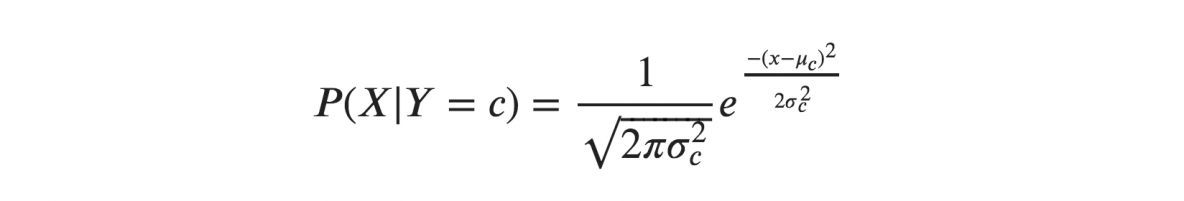

**5. Explain your solution.**  
The solution is to use the **var_smoothing** parameter which is a portion that will be added to variance which help with the stability of the calculations. In this way, the variance is no longer zero or too clase to zero, and the estimation of conditional probabilities is not impacted. As it can be seen in the sumamry table, the minimum variance for the model with smoothing is no longer zero (it is 0.0201), which helps to improve the accuracy of the model.

**Note:** I also explored normalizing the image -> (image - mean(image) / std(image)) - while the accuracy went up to 0.704, it is not as significant as using the var_smoothing parameter.

Definition from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html  
- **sigma_** ndarray of shape (n_classes, n_features) - variance of each feature per class  
- **theta_** ndarray of shape (n_classes, n_features) - mean of each feature per class  
- **var_smoothing** - float, default=1e-9 - Portion of the largest variance of all features that is added to variances for calculation stability.  

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



In [126]:
def gen_num(pm, adj_filter1, adj_filter2):
    
    #This filter is used to set to one only relatively high probabilities (so that edges are clean)
    filter1 = pm > pm.mean()*adj_filter2
    
    #Generate random 28 by 28 matrix of 0 to 1 numbers
    n = np.random.rand(28,28)
    
    #Set to zero the randomly generated numbers that are relatively low (to help to clean edges)
    n = n * filter1
    
    #Multiply by probability for each pixel of the digit which activate pixels with high probability
    n = n * pm
    
    #Binarize to help increase contrast for the image
    n = np.where(n > n.mean()*adj_filter1, 1, 0)
    return(n)   

Model 1 - accuracy: 0.81


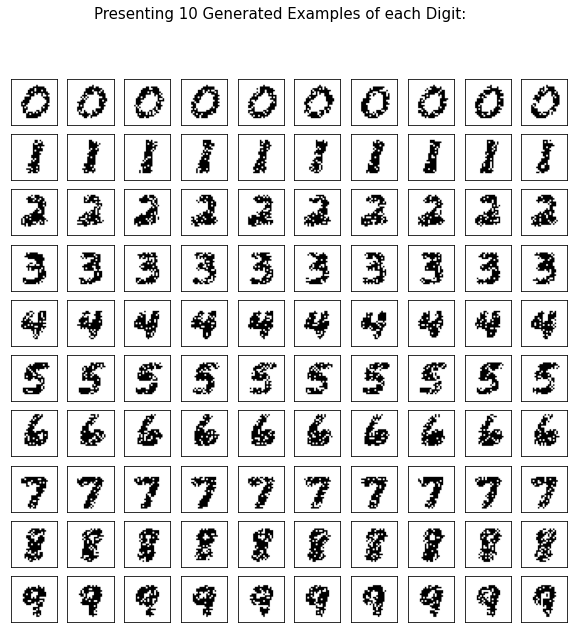

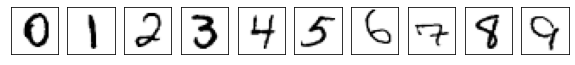

In [158]:
def Q5(num_examples, train_data, train_labels):

### STUDENT START ###

    #Set, fit and print accuracy of BernoulliNB model
    alpha = 1
    clf2 = BernoulliNB(alpha=alpha, binarize=0.1)
    clf2.fit(train_data, train_labels)
    print ('Model 1 - accuracy: %3.2f' %clf2.score(dev_data, dev_labels))
    
    #Get probability matrix for pixels for each digit (convert back to probability using np.exp)
    prob = np.exp(clf2.feature_log_prob_)
    
    #Create figure2 with number of subplots to accomodate number of examples
    fig2, axs_q5 = plt.subplots(nrows=10, ncols=num_examples, figsize=(num_examples,10))

    # Turn off tick marks.
    plt.setp(axs_q5, xticks=(), yticks=())
    
    #Plot 10 examples of each digit
    for i in range(10):
        pm = np.reshape(prob[i], (28,28))
        for j in range(num_examples):
            axs_q5[i,j].imshow(gen_num(pm, 2, 2), cmap=plt.cm.Greys)
    
    fig2.suptitle('Presenting {} Generated Examples of each Digit:'.format(num_examples), fontsize=15, )
    
    #Create figure2_1 with number of subplots to accomodate original train digits
    fig2_1, axs_q5_1 = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
    
    # Turn off tick marks.
    plt.setp(axs_q5_1, xticks=(), yticks=())
    
    #Present one example of each digit from the train data
    counter = np.zeros(10)
    i = 0
    while (counter.sum() < 10):
        num = int(train_labels[i])
        if counter[num] == 0:
            axs_q5_1[num].imshow(np.reshape(train_data[i,:],(28,28)), cmap=plt.cm.Greys)
            counter[num] += 1
        i += 1
        
    #fig2_1.suptitle('Training Digits:'.format(num_examples), fontsize=15)
     
 
    ### STUDENT END ###

Q5(10, mini_train_data, mini_train_labels)

**ANSWER: How do the generated digit images compare to the training digit images?**  
The generated digits show some variations across them.  However, when compared with the original digits (from train_data), the generated digits have a less defined shape, which reflects the wide range of probabilities associated to the pixels for each digit.  The graph above presents the 10 generated examples for each digit, and the last plots presents examples of the original digits. 

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



Model Accuracy: 0.83
                      Bucket Range  Bucket Size  Accuracy
0                          (0-0.5)            0     0.000
1                        (0.5-0.9)           34     0.412
2                      (0.9-0.999)           64     0.500
3                  (0.999-0.99999)           57     0.579
4              (0.99999-0.9999999)           45     0.600
5          (0.9999999-0.999999999)           50     0.660
6      (0.999999999-0.99999999999)           50     0.780
7  (0.99999999999-0.9999999999999)           66     0.758
8            (0.9999999999999-1.0)          634     0.950


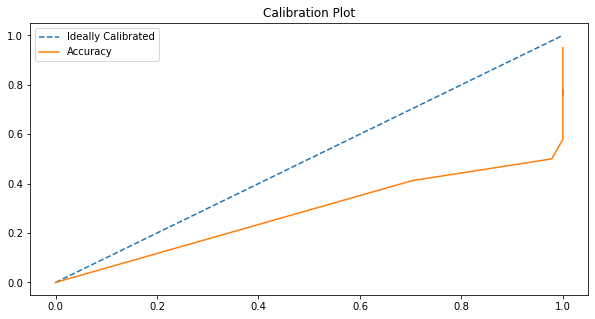

In [162]:
def Q6(buckets, correct, total, mini_train_data, mini_train_labels, dev_data, dev_labels):
    
### STUDENT START ###

    #Set, fit and print accuracy of BernoulliNB model
    alpha = 0.001
    clf2 = BernoulliNB(alpha=alpha, binarize=0)
    clf2.fit(train_data, train_labels)
    print ('Model Accuracy: %3.2f' %clf2.score(dev_data, dev_labels))
    
    #Create a dataframe with posterior probabilities and add a column with the maximum of each row
    predict_proba = pd.DataFrame(clf2.predict_proba(dev_data))
    predict_proba['maxcol'] = predict_proba.apply(lambda row: row.max(), axis = 1)    
     
    #Initialize lists to store the required information
    bucket_range = []      #To store the range for each bucket (strings)
    count = []             #To store the number of observations identified in each bucket
    accuracy = []          #To store actual accuracy using the observations identified for each bucket
    posterior = []         #Store mid point of each bucket as representative posterior probability for the bucket
    
    #Initialize lower level for first bucket in zero.
    p_before = 0
    
    #Store the maximum posterior probability of each row in post.
    post = predict_proba['maxcol']
    
    #For each value in the bucket
    for b in buckets:
        bucket_range.append("("+str(p_before)+"-"+str(b)+")")                             #Store the range for bucket
        pp_mask= (predict_proba['maxcol'] <= b) & (predict_proba['maxcol'] >= p_before)   #Create mask for values in bucket
        p_before = b                                                                      #Move low range of bucket
        td1 = dev_data[pp_mask]                               #Get training data aligned with mask for bucket
        tl1 = dev_labels[pp_mask]                             #Get development data aligned with mask for bucket
        if td1.shape[0] > 0:                                  #If the number of observations is greater than zero
            posterior.append(round(post[pp_mask].mean(),3))           #Store the mean of posterior for obser. in bucket
            accuracy.append(round(clf2.score(td1, tl1),3))            #Store accuracy using observations in bucket
            count.append(td1.shape[0])                                #Store the number of observations for the bucket
        else:
            posterior.append(0)   #Fill with zeros, if no observations in bucket
            accuracy.append(0)
            count.append(0)
    
    #Create and pring Summary DataFrame with Bucket Range, Size and Accuracy
    df_summary = pd.DataFrame({"Bucket Range": bucket_range,
                               "Bucket Size": count,
                                "Accuracy": accuracy})
    print(df_summary)
    
    #Plot Calibration Plot
    fig1, axs_q61 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    axs_q61.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
    axs_q61.plot(posterior, accuracy, label = 'Accuracy')
    plt.title("Calibration Plot")
    axs_q61.legend()
    
    
    return (predict_proba)

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

pp = Q6(buckets, correct, total, mini_train_data, mini_train_labels, dev_data, dev_labels)

**ANSWER: How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?**  
Based on the calculated accuracy, the model is a **weakly calibrated classifier**.  As it can be seen in the graph above, the accuracy increases as the posterior probability increases.  However, the actual accuracy is consistently below the ideally calibrated line (in blue).  In other words, the actual accuracy is higher when the model's estimated posterior probability is higher, but it is below the ideally calibrated line.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [170]:
def add_mean(train_data, adj_filter1):
    #Function to add the mean for each row and each column
    list_td = []
    
    #for each image (td) in train data, it adds the mean of the row and the mean of the column.
    for td in train_data:
        #Create a dataframe with the image (28 x 28)
        figure = pd.DataFrame(np.reshape(td, (28,28)))
        
        #Add the mean to the row
        figure[figure.shape[1]] = figure.apply(lambda row: row.mean(), axis = 1)
        
        #Add the sum of the column
        figure.loc[len(figure.index)] = figure.sum()
        figurea = figure.values
        
        #Further binarize image
        figurea = np.where(figurea > figurea.mean()*adj_filter1, 1, 0)
        figurea = np.reshape(figurea, (29*29))
        list_td.append(figurea)
    return(np.array(list_td))
        

In [171]:
def add_moving_average(train_data, adj_filter1, adj_filter2):
    #Add moving average to each column of the figure
    list_td = []
    # for each image (td) in train data, add the moving average 
    for td in train_data:
        #Create a dataframe out of the current figure (td)
        fig = pd.DataFrame(np.reshape(td, (28,28)))
        #for each column add a column with a moving average of adj_filter1
        for i in range(0,fig.shape[1]):
            fig[fig.shape[1]+1] = fig.iloc[:,i].rolling(window=adj_filter1).mean() #Moving Average / Rolling Average
            #fig[fig.shape[1]+1] = fig.iloc[:,i].ewm(span=40,adjust=False).mean()  #Exponential Moving Average
            #fig[fig.shape[1]+1] = fig.iloc[:,i].expanding(min_periods=adj_filter1).mean()  #Exponential Moving Average
 
        #Fill with zero any NA value
        fig = fig.fillna(0)
        figArray = fig.values
        #Further binarize values
        figArray = np.where(figArray > figArray.mean()*adj_filter2, 1, 0)
        figArray = np.reshape(figArray, (fig.shape[0]*fig.shape[1]))
        list_td.append(figArray)
    return(np.array(list_td))

In [165]:
def max_pool(f, factor):
    
    #Apply Max Pool to figure (f)
    
    #Create an array of zeros with half the dimensions of figure to store max pool calculations
    fb = np.zeros( ( int(f.shape[0]/2), int(f.shape[1]/2) ) )
    
    #Go through each pixel in the image (f)
    n = 0
    i = factor
    while i < f.shape[0]:
        j = factor
        m = 0
        while j < f.shape[1]:
            #Get the pixel and three other neighbors (2 x 2 matrix)
            fpoint = f[i-factor:i+factor, j-factor:j+factor]
            #Assign the maximum value of selected 2x2 matrix to fb (where max_pool figure is stored)
            fb[n,m] = fpoint.max()
            j += (factor+1)
            m += 1
        i += (factor+1)
        n +=1
    return(fb)

def max_pooling(data, factor, adj):
    #Function to do Max Pooling to each image in Data
    fig_list = []
    #For each image in data, do max_pool of the figure, reshape it, and add to list of max_pooled images.
    for image in data:
        figure = np.reshape(image,(28,28))
        fig_max_pool = max_pool(figure, factor)
        fig_max_pool = np.reshape(fig_max_pool,(fig_max_pool.shape[0]*fig_max_pool.shape[1]))
        fig_max_pool = np.where(fig_max_pool > fig_max_pool.mean()*adj, 1, 0)        
        fig_list.append(fig_max_pool)
    return (np.array(fig_list))  

In [177]:
def Q7(train_data, train_labels, dev_data, dev_labels):

### STUDENT START ###

    alpha = 0.001
    
    #List to store the model information
    mod_description = []             #Store Model Description
    mod_number_features = []         #Store Number of features used
    mod_accuracy = []                #Store Model Accuracy

    #Set and fit BernoulliNB model with no new features (basic model)
    clf1 = BernoulliNB(alpha=alpha, binarize=0)
    clf1.fit(train_data, train_labels)
    #Store model description, number of features, and accuracy
    mod_description.append("No new Features")
    mod_number_features.append(train_data.shape[1])
    mod_accuracy.append(clf1.score(dev_data, dev_labels))
    
    #Add mean to rows and total sum to columns, plus binarize pixels (using adf_factor)
    adj_factor = 0.899
    new_train_data = add_mean(train_data,adj_factor)
    new_dev_data = add_mean(dev_data,adj_factor)
    
    #Set and fit model using additional features (row mean and sum for columsn)
    clf2 = BernoulliNB(alpha=alpha, binarize=0)
    clf2.fit(new_train_data, train_labels)
    #Store model description, number of features, and accuracy    
    mod_description.append("Mean & Sum (row & col), binarize")
    mod_number_features.append(new_train_data.shape[1])
    mod_accuracy.append(clf2.score(new_dev_data, dev_labels))

    #Concatenate augmented matrix (with mean and sum) to original matrix.
    new_td_from_m2 = np.concatenate((train_data, new_train_data), axis=1)
    new_dd_from_m2 = np.concatenate((dev_data, new_dev_data), axis=1)
    #Set and fit model using original image plus augmented image with row average and column sum
    clf2_1 = BernoulliNB(alpha=alpha, binarize=0)
    clf2_1.fit(new_td_from_m2, train_labels)
    #Store model description, number of features, and accuracy    
    mod_description.append("Original matrix + previous")
    mod_number_features.append(new_td_from_m2.shape[1])
    mod_accuracy.append(clf2_1.score(new_dd_from_m2, dev_labels))
    
    #Add Moving Average to the image
    adj_factor = 3  #Number of steps for moving average
    new_td_moving_avg = add_moving_average(train_data,adj_factor,0.899)
    new_dd_moving_avg = add_moving_average(dev_data,adj_factor, 0.899)

    #Set and fit BernoulliNB model with moving average for each column
    clf3 = BernoulliNB(alpha=alpha, binarize=0)
    clf3.fit(new_td_moving_avg, train_labels)
    #Store model description, number of features, and accuracy    
    mod_description.append("Including Moving Average")
    mod_number_features.append(new_td_moving_avg.shape[1])
    mod_accuracy.append(clf3.score(new_dd_moving_avg, dev_labels))

    #Apply Max_pooling to images
    new_td_max_pooled = max_pooling(train_data,1, 3)
    new_dd_max_pooled = max_pooling(dev_data,1, 3)

    #Set and fit BernoulliNB model using Max_pooled image
    clf4 = BernoulliNB(alpha=alpha, binarize=0)
    clf4.fit(new_td_max_pooled, train_labels)
    #Store model description, number of features, and accuracy        
    mod_description.append("Applying Max Pooled")
    mod_number_features.append(new_td_max_pooled.shape[1])
    mod_accuracy.append(clf4.score(new_dd_max_pooled, dev_labels))

    #Concatenate the Maxpooled matrix to original matrix.
    new_td_plus_mp = np.concatenate((train_data, new_td_max_pooled), axis=1)
    new_dev_plus_mp = np.concatenate((dev_data, new_dd_max_pooled), axis=1)

    #Set and fit BernoulliNB model using Original Image plus Max_pooled image
    clf5 = BernoulliNB(alpha=alpha, binarize=0)
    clf5.fit(new_td_plus_mp, train_labels)
    #Store model description, number of features, and accuracy            
    mod_description.append("Original matrix + Max Pool")
    mod_number_features.append(new_td_plus_mp.shape[1])
    mod_accuracy.append(clf5.score(new_dev_plus_mp, dev_labels))

    #Create Kernel for blurring images
    matrix_kernel = np.reshape(np.array([1,2,1,2,4,2,1,2,1]),(3,3))
    kernelG = matrix_kernel/matrix_kernel.sum()
    
    #Blur images
    train_data_blr = blur_data_set(train_data, kernelG)
    dev_data_blr = blur_data_set(dev_data, kernelG)

    #Set and fit BernoullNB model using blurred images
    clf6 = BernoulliNB(alpha=alpha, binarize=0)
    clf6.fit(train_data_blr, train_labels)
    #Store model description, number of features, and accuracy                
    mod_description.append("Blurred figure")
    mod_number_features.append(train_data_blr.shape[1])
    mod_accuracy.append(clf6.score(dev_data_blr, dev_labels))

    #Concatenate the blurred matrix to original matrix.
    new_train_plus_blur = np.concatenate((train_data, train_data_blr), axis=1)
    new_dev_plus_blur = np.concatenate((dev_data, dev_data_blr), axis=1)

    #Set and fit BernoullNB model using original image plus blurred images
    clf7 = BernoulliNB(alpha=alpha, binarize=0)
    clf7.fit(new_train_plus_blur, train_labels)
    #Store model description, number of features, and accuracy                
    mod_description.append("Original matrix + blurred")
    mod_number_features.append(new_train_plus_blur.shape[1])
    mod_accuracy.append(clf7.score(new_dev_plus_blur, dev_labels))
    
    #Create dataframe with summary information for model and print summary table
    df_summary = pd.DataFrame({"Model Description": mod_description,
                               "Number of Features": mod_number_features,
                               "Model Accuracy":mod_accuracy })
    
    print(df_summary)

    
### STUDENT END ###

Q7(mini_train_data, mini_train_labels, dev_data, dev_labels)

                  Model Description  Number of Features  Model Accuracy
0                   No new Features                 784           0.823
1  Mean & Sum (row & col), binarize                 841           0.838
2        Original matrix + previous                1625           0.835
3          Including Moving Average                1568           0.829
4               Applying Max Pooled                 196           0.812
5        Original matrix + Max Pool                 980           0.830
6                    Blurred figure                 784           0.794
7         Original matrix + blurred                1568           0.812


**ANSWER: Six different approaches were tested.  However, the accuracy did not significantly increase.**
* Models that were able to slightly improve accuracy were:
 - (Line 1) Adding mean to rows and totals to columns (plus some binarization) -> accuracy went up to 0.838 from 0.823 (using 841 features)
 - (Line 5) Adding the Max Pool image to the original image -> accuracy went up to 0.830 from 0.823 (using 980 features)
  
* Interesting that accuracy did not suffer much using only Max Pool (line 4).  By using Max pooling, the size of image went down from 784 features to 196 features.  However, the accuracy did not suffer much (went down from 0.823 to 0.812).